## San Francisco Crime Prediction
### Machine Learning I - ZHAW SoE - DS21a

Gérôme Meyer, Lea Keller, Alessio Drigatti

For this assignment we joined a kaggle challenge from 2014. Kaggle provides a dataset with nearly 12 years of crime reports from across all of San Francisco's neighborhoods. The dataset provides information about the exact time, the category of the incident, a description of the incident, the day of week, the name of de police department district, how the incident was resolved, approximate street address, geographical longitude and geographical latitude.
The goal is to predict the category of an incident, given time and location.

In [4]:
# import warnings
# warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

## Data exploration

/home/gero/Projects/san-francisco-crime/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


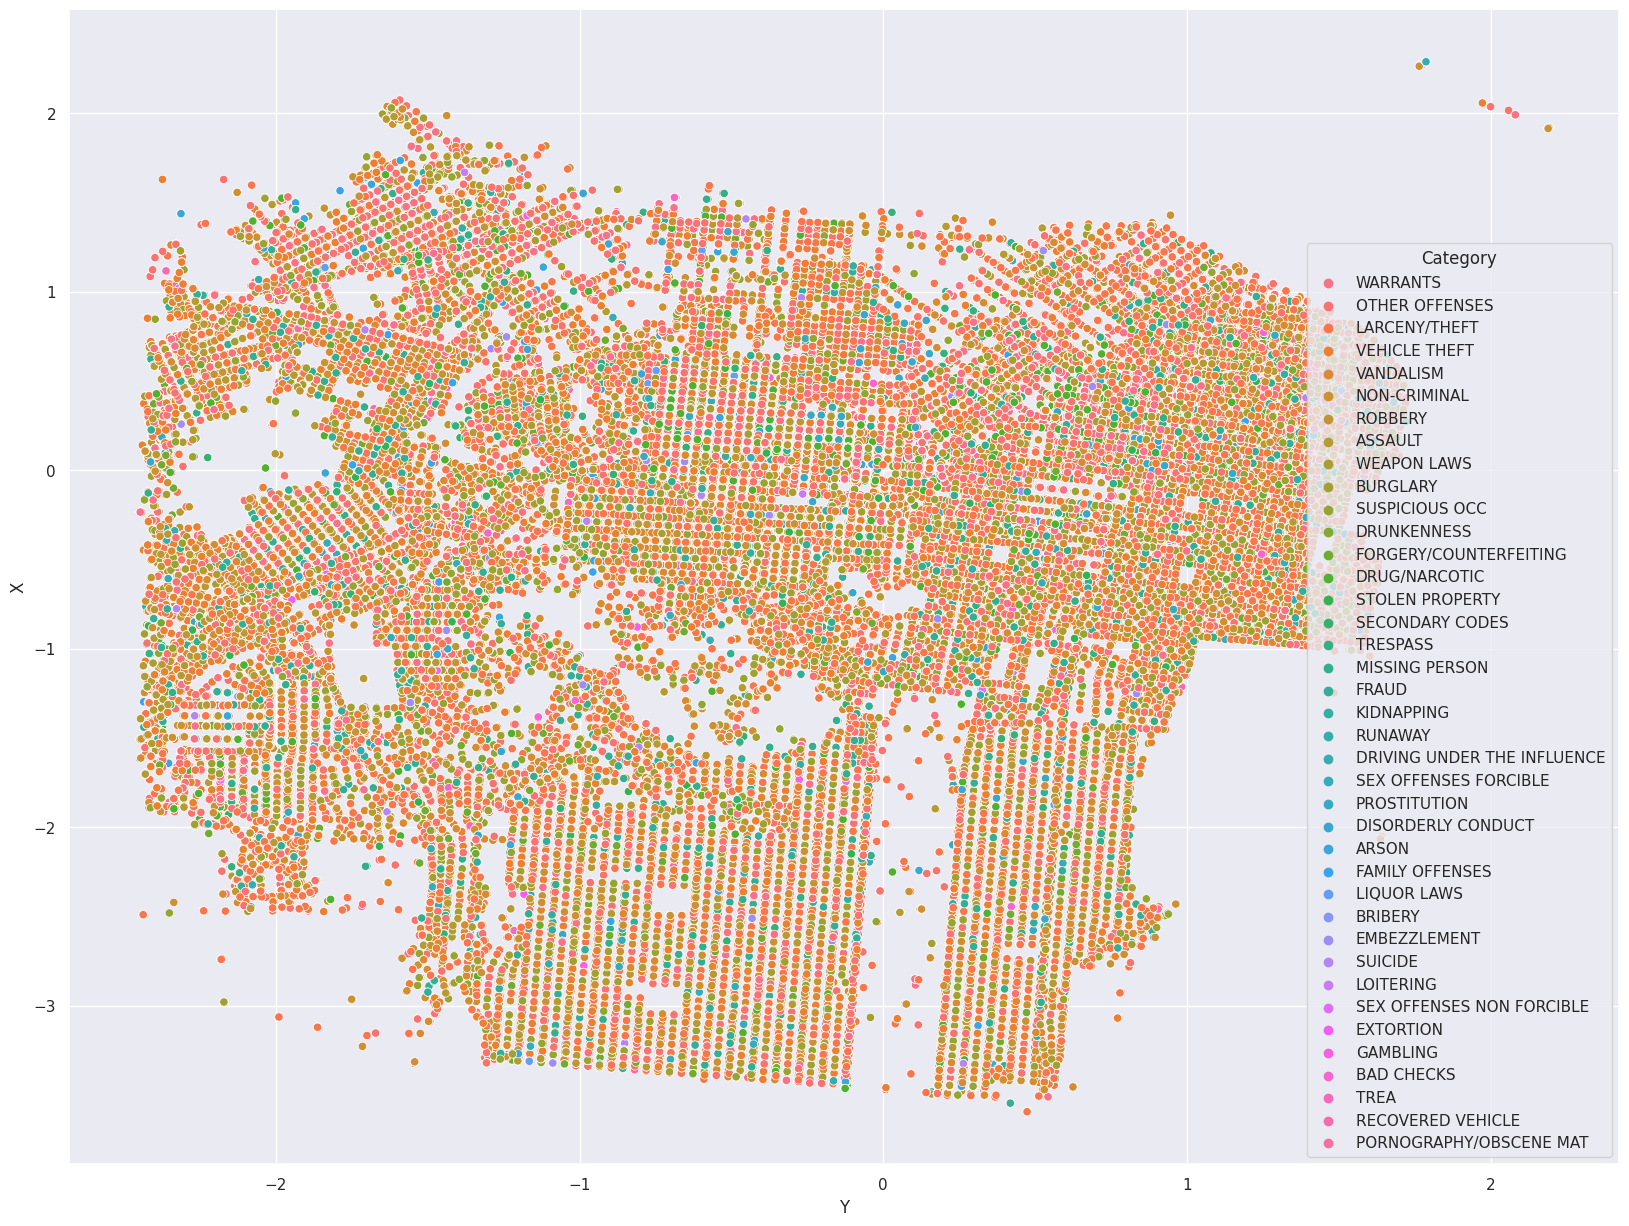

In [2]:
data = pd.read_csv('../data/train.csv')

# There seems to be invalid data that contains latitude = 90. (Which would be the North Pole)
data = data[data['Y'] != 90]
data = data[data['Category'] != 'NONE']

standard_scaler = StandardScaler()
x = np.asarray(data['X']).reshape((-1, 1))
y = np.asarray(data['Y']).reshape((-1, 1))
data['X'] = StandardScaler().fit_transform(x)
data['Y'] = StandardScaler().fit_transform(y)

sns.set(rc={'figure.figsize': (20, 15)})
sns.scatterplot(data, x='Y', y='X', hue='Category')
plt.show()

## Data cleaning and feature engineering
First, we imported the data and deleted data with invalid latitude. Then we dropped the variables, which are not part of the test data.

In [37]:
data = pd.read_csv('../data/train.csv')

# There seems to be invalid data that contains latitude = 90. (Which would be the North Pole)
# data = data[data['Y'] != 90]

In [38]:
y_train = data['Category']

# The description and category are not part of the test data, therefore we cannot use them for training.
# And we need to drop the resolution variable since it is our target variable and also not part of the test data.
x_train = data.drop(['Descript', 'Category', 'Resolution'], axis=1)

Then we separated the date informations in the subcomponents year, month, day, hour and minute and saved them as floats. We added the category federal holiday and set the name based on the date. We have also added two additional categories "isday" and "IsWeekend". The categorisation if it is day or night is based on the hour (time) and the categorisation if it is a weekday or the weekend is based on the day of week.
After the new categories were added the information of the full date is no longer needed, so we dropped it.

In [39]:
def map_address_to_address_type(addr):
    addr_type = 0.
    # Address types:
    #  Intersection: 1
    #  Residence: 0
    if '/' in addr and 'of' not in addr:
        addr_type = 1.
    return addr_type


def feature_engineering(data_frame):
    # Split the date into its subcomponents
    data_frame[['year', 'month', 'day', 'hour', 'minute']] = data_frame.Dates.str.extract(
        '(?P<year>\d{4})-(?P<month>\d{2})-(?P<day>\d{2}) (?P<hour>\d{2}):(?P<minute>\d{2})'
    )

    # Convert the date numbers into actual integers
    data_frame = data_frame.astype({
        'year': 'float64',
        'month': 'float64',
        'day': 'float64',
        'hour': 'float64',
        'minute': 'float64',
    })

    federal_holidays = [
        {'pattern': '\d{4}-01-01', 'name': 'new_year'},
        {'pattern': '\d{4}-07-04', 'name': 'independence_day'},
        {'pattern': '\d{4}-11-24', 'name': 'thanksgiving'},
        {'pattern': '\d{4}-12-25', 'name': 'christmas_day'},
        {'pattern': '\d{4}-12-25', 'name': 'christmas_day'},
        {'pattern': '\d{4}-12-26', 'name': 'christmas_day'},
        {'pattern': '\d{4}-12-31', 'name': 'new_year'},
    ]

    data_frame["federal_holiday"] = "None"
    for holiday in federal_holidays:
        data_frame.loc[data_frame['Dates'].str.match(holiday['pattern']), 'federal_holiday'] = holiday['name']

    # We no longer need the "Dates" variable, so we drop it.
    data_frame.drop(['Dates'], inplace=True, axis=1)

    data_frame.loc[data_frame['hour'] <= 7, 'isday'] = 0
    data_frame.loc[data_frame['hour'] > 7, 'isday'] = 1
    data_frame.loc[data_frame['hour'] > 19, 'isday'] = 0

    data_frame["IsWeekend"] = 0
    data_frame.loc[data_frame['DayOfWeek'] == 'Sunday', 'IsWeekend'] = 1
    data_frame.loc[data_frame['DayOfWeek'] == 'Saturday', 'IsWeekend'] = 1

    data_frame['Address_Type'] = list(map(map_address_to_address_type, data_frame.Address))
    data_frame = data_frame.astype({
        'Address_Type': 'float64',
    })
    data_frame.drop(['Address'], inplace=True, axis=1)

    # One-Hot encoding for the DayOfTheWeek
    column_transformer = make_column_transformer(
        (OneHotEncoder(), ['DayOfWeek', 'PdDistrict', 'federal_holiday']),
        (StandardScaler(), ['X', 'Y', 'year', 'month', 'day', 'hour', 'minute']),
        remainder='passthrough'
    )

    data_transformed = column_transformer.fit_transform(data_frame)
    data_frame = pd.DataFrame(data=data_transformed, columns=column_transformer.get_feature_names_out())

    data_frame = data_frame.rename(
        columns={element: re.sub(r'^(.+)__', '', element) for element in data_frame.columns.tolist()})

    return data_frame

In [40]:
x_train = feature_engineering(x_train)

# TODO Gérôme

In [41]:
x_train.to_csv('../data/x_train_cleaned.csv', index=False)
y_train.to_csv('../data/y_train_cleaned.csv', index=False)

x_train.head(10)

,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,PdDistrict_BAYVIEW,PdDistrict_CENTRAL,PdDistrict_INGLESIDE,...,X,Y,year,month,day,hour,minute,isday,IsWeekend,Address_Type
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.107902,0.007832,1.73165,-0.418933,-0.292682,1.463813,1.766343,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.107902,0.007832,1.73165,-0.418933,-0.292682,1.463813,1.766343,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.057541,0.064335,1.73165,-0.418933,-0.292682,1.463813,0.690779,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.144262,0.065338,1.73165,-0.418933,-0.292682,1.463813,0.529445,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.531112,0.001140,1.73165,-0.418933,-0.292682,1.463813,0.529445,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.637950,-0.126046,1.73165,-0.418933,-0.292682,1.463813,0.529445,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,-0.023408,-0.100422,1.73165,-0.418933,-0.292682,1.463813,0.529445,0.0,0.0,1.0
7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.691468,-0.095113,1.73165,-0.418933,-0.292682,1.463813,0.529445,0.0,0.0,1.0
8,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-2.819355,0.012215,1.73165,-0.418933,-0.292682,1.463813,-1.083900,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.116256,0.080503,1.73165,-0.418933,-0.292682,1.463813,-1.083900,0.0,0.0,1.0


## Model Implementation

In order to try and predict the category we trained a fully-connected sequential Neural Network on the training data from Kaggle.


Architecture:
- Input Layer with a Neuron for each feature
- Hidden Layer with **2560** Neurons
- Hidden Layer with **780** Neurons
- Output Layer with **39** Categories

The output of the hidden Layers is normalized with a "[BatchNormalization](https://keras.io/api/layers/normalization_layers/batch_normalization/)" Layer.


Note: The code below contains a commented section that can be uncommented to work with only a fraction of the data which is useful for trying out different architecures.

First we import the following libraries:
- matplotlib to plot the score of the model
- pandas to read and transform our data that we created earlier
- kears for the actual Neural Network
- sklearn (Scikit-Learn) for some more data preprocessing and splitting
- numpy for when we wish to reduce

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
from keras.layers import Dense, Conv1D, Dropout, MaxPooling1D, Flatten
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

Next we read the data from the files created earlier.

In [43]:
x_clean = pd.read_csv('../data/x_train_cleaned.csv')
y_clean = pd.read_csv('../data/y_train_cleaned.csv')

For architecture experimentation you can run this cell with a custom `drop_data_fraction`.
E.g. with `drop_data_fraction = 0.9`, you would work with ~10% of the data, therefore reducing training time.

To train with all data, set `drop_data_fraction = 0`.

In [44]:
drop_data_fraction = 0
drop_indices = np.random.choice(x_clean.index, int(len(x_clean) * drop_data_fraction), replace=False)
x_clean = x_clean.drop(drop_indices)
y_clean = y_clean.drop(drop_indices)

Now we can split the data to into training and test data. We need the test part of the data to evaluate how well our model will deal with similar data that it hasn't seen yet.
Also we encode the string descriptions of the category into numbers since our model cannot be trained to predict strings.

In [45]:
label_encoder = LabelEncoder()
y_clean = label_encoder.fit_transform(y_clean['Category'])

x_train, x_test, y_train, y_test = train_test_split(x_clean, y_clean)

### Model definition

Creation of the model and its

[ 0.          0.          0.          0.          0.          0.
  1.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          1.0968167  -0.0715901
 -1.57304985 -1.29383121  0.39045621  0.08967695 -1.08390046  1.
  0.          0.        ]
Epoch 1/10
19757/19757 [==============================] - 197s 10ms/step - loss: 2.6938 - accuracy: 0.1720 - val_loss: 2.6891 - val_accuracy: 0.1975
Epoch 2/10
19757/19757 [==============================] - 178s 9ms/step - loss: 2.6878 - accuracy: 0.1609 - val_loss: 2.6913 - val_accuracy: 0.1459
Epoch 3/10
19757/19757 [==============================] - 189s 10ms/step - loss: 2.6845 - accuracy: 0.1943 - val_loss: 2.6866 - val_accuracy: 0.1975
Epoch 4/10
19757/19757 [==============================] - 187s 9ms/step - loss: 2.6827 - accuracy: 0.1994 - val_loss: 2.6857 - val_accuracy: 0.1975
Epoch 5/10
19757/19757 [========================

INFO:tensorflow:Assets written to: ./small_model/assets


INFO:tensorflow:Assets written to: ./small_model/assets


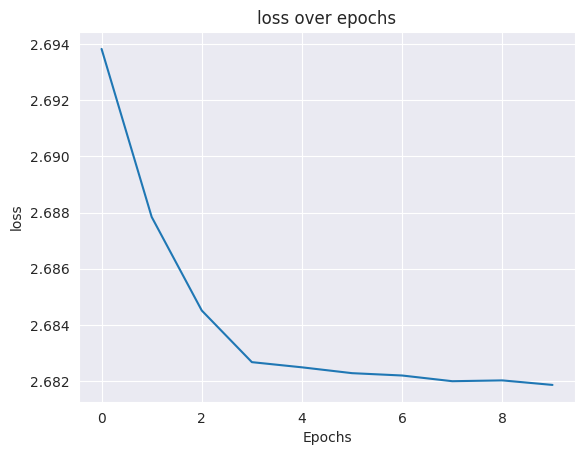

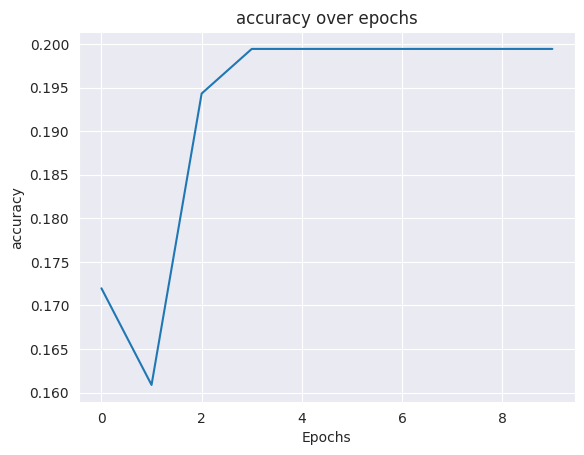

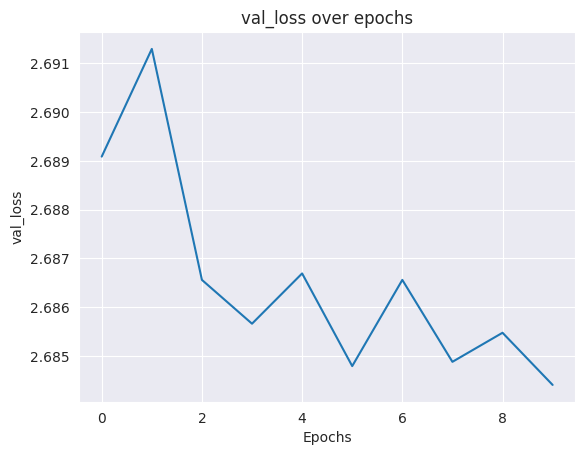

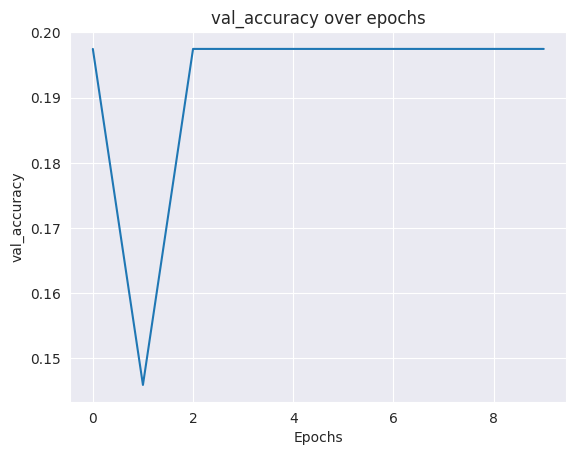

6860/6860 [==============================] - 13s 2ms/step - loss: 2.6819 - accuracy: 0.1991
Highest accuracy: 0.1974671185016632
Loss: 2.6818532943725586
Accuracy: 0.19905883073806763


In [46]:
model = Sequential(name='san_francisco_sequential')

x_train_np = x_train.to_numpy()
x_train_np.reshape(x_train_np.shape[0], x_train_np.shape[1], 1)

print(x_train_np[0])

model.add(Conv1D(filters=32, kernel_size=2, activation='relu', padding='same', input_shape=(32, 1)))
model.add(MaxPooling1D())
model.add(Flatten())

amount_of_hidden_layers = 15

for layer_index in range(amount_of_hidden_layers):
    model.add(Dense(300, activation='relu'))
    model.add(Dropout(0.2))

# Output Layer for 39 categories
model.add(Dense(39, activation='softplus'))

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(
    x_train_np,
    y_train,
    batch_size=30,
    epochs=10,
    validation_split=.1
)

model.save('./small_model')

highest_val_accuracy = max(history.history['val_accuracy'])

for j in list(history.history.keys()):
    plt.plot(history.history[j])
    plt.title(j + ' over epochs')
    plt.ylabel(j)
    plt.xlabel('Epochs')
    plt.show()

evaluation = model.evaluate(x_test, y_test)
print(f"Highest accuracy: {highest_val_accuracy}")
print(f"Loss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")

## Generate Kaggle Submission

2.2181886278116716


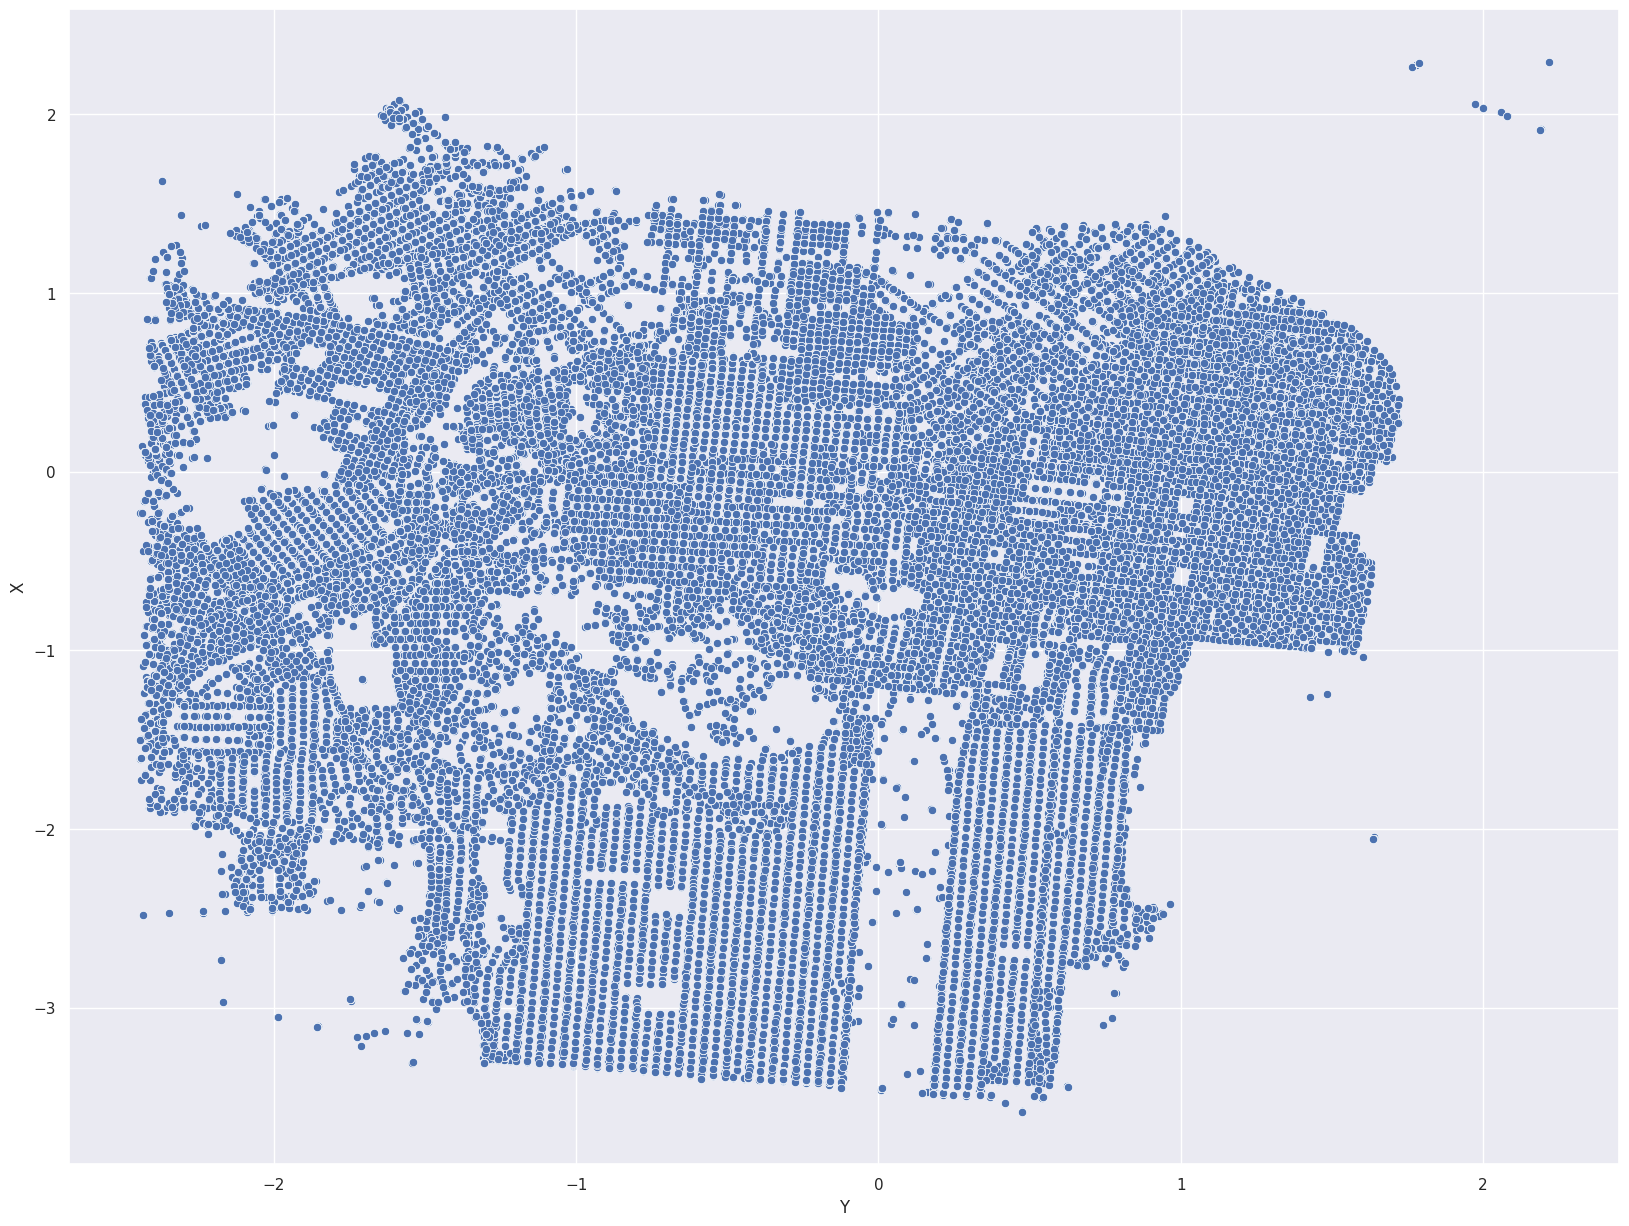

In [48]:
data = pd.read_csv('../data/test.csv')

# There seems to be invalid data that contains latitude = 90. (Which would be the North Pole)
data = data[data['Y'] != 90]

standard_scaler = StandardScaler()
x = np.asarray(data['X']).reshape((-1, 1))
y = np.asarray(data['Y']).reshape((-1, 1))
data['X'] = StandardScaler().fit_transform(x)
data['Y'] = StandardScaler().fit_transform(y)

print(data['Y'].max())

sns.set(rc={'figure.figsize': (20, 15)})
sns.scatterplot(data, x='Y', y='X')
plt.show()

In [17]:
data = pd.read_csv('../data/test.csv')

data = feature_engineering(data)

data.to_csv('../data/test_cleaned.csv', index=False)

data

,DayOfWeek_Friday,DayOfWeek_Monday,DayOfWeek_Saturday,DayOfWeek_Sunday,DayOfWeek_Thursday,DayOfWeek_Tuesday,DayOfWeek_Wednesday,PdDistrict_BAYVIEW,PdDistrict_CENTRAL,PdDistrict_INGLESIDE,...,Y,year,month,day,hour,minute,Id,isday,IsWeekend,Address_Type
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.075130,1.730764,-0.379014,-0.636670,1.464267,2.087371,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.080531,1.730764,-0.379014,-0.636670,1.464267,1.657505,1.0,0.0,1.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.042772,1.730764,-0.379014,-0.636670,1.464267,1.603771,2.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.103262,1.730764,-0.379014,-0.636670,1.464267,1.335105,3.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.103262,1.730764,-0.379014,-0.636670,1.464267,1.335105,4.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884257,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.040198,-1.567889,-1.532728,-1.650781,-2.042421,-1.029158,884257.0,0.0,0.0,0.0
884258,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.043739,-1.567889,-1.532728,-1.650781,-2.042421,-1.029158,884258.0,0.0,0.0,0.0
884259,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,-0.122521,-1.567889,-1.532728,-1.650781,-2.042421,-1.029158,884259.0,0.0,0.0,0.0
884260,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,-0.065996,-1.567889,-1.532728,-1.650781,-2.042421,-1.029158,884260.0,0.0,0.0,0.0


### Generate predictions a submission file

In [26]:
import keras
import pandas as pd

categories = ['ARSON', 'ASSAULT', 'BAD CHECKS', 'BRIBERY', 'BURGLARY', 'DISORDERLY CONDUCT',
              'DRIVING UNDER THE INFLUENCE', 'DRUG/NARCOTIC', 'DRUNKENNESS', 'EMBEZZLEMENT', 'EXTORTION',
              'FAMILY OFFENSES', 'FORGERY/COUNTERFEITING', 'FRAUD', 'GAMBLING', 'KIDNAPPING', 'LARCENY/THEFT',
              'LIQUOR LAWS', 'LOITERING', 'MISSING PERSON', 'NON-CRIMINAL', 'OTHER OFFENSES', 'PORNOGRAPHY/OBSCENE MAT',
              'PROSTITUTION', 'RECOVERED VEHICLE', 'ROBBERY', 'RUNAWAY', 'SECONDARY CODES', 'SEX OFFENSES FORCIBLE',
              'SEX OFFENSES NON FORCIBLE', 'STOLEN PROPERTY', 'SUICIDE', 'SUSPICIOUS OCC', 'TREA', 'TRESPASS',
              'VANDALISM', 'VEHICLE THEFT', 'WARRANTS', 'WEAPON LAWS']

model = keras.models.load_model('./small_model')
df = pd.read_csv('../data/test_cleaned.csv')

df.drop('Id', axis=1, inplace=True)

arr = df.to_numpy()

predictions = model.predict(arr)

for prediction in predictions:
    prediction_max = prediction.max()
    prediction[prediction != prediction_max] = 0
    prediction[prediction != 0] = 1

print(predictions.shape)

predictions = predictions.astype('int32')

df_predictions = pd.DataFrame(predictions, columns=categories)

df_predictions.to_csv('predictions.csv', index_label='Id')

27634/27634 [==============================] - 248s 9ms/step
(884262, 39)
